In [1]:
import jax
import jax.numpy as jnp
from evosax import ParameterReshaper
import ipyplot
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/Users/erpl/anaconda3/envs/metandp/lib/python3.11/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/erpl/anaconda3/envs/metandp/lib/python3.11/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/erpl/anaconda3/envs/metandp/lib/python3.11/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


# Setup

### Create environment

In [2]:
import gymnax as gym

/Users/erpl/anaconda3/envs/metandp/lib/python3.11/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/erpl/anaconda3/envs/metandp/lib/python3.11/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [3]:
env_name = "MountainCar-v0"
env, env_params = gym.make(env_name)
n_actions = env.action_space(env_params).n
obs_dims = env.observation_space(env_params).shape[0]

In [4]:
env_steps = env_params.max_steps_in_episode

### Create NDP and Policy

In [5]:
from models import HyperNCA, HyperNCA_Config
from policies import MLPPolicy

In [6]:
# MLP configuration
mlp_hidden_dims = 4 # nb of features for each hidden layer
mlp_hidden_layers = 1 # nb of hidden layers
mlp_action_dims = n_actions 
mlp_obs_dims = obs_dims

In [7]:
policy = MLPPolicy(mlp_action_dims, mlp_hidden_layers,
                  mlp_hidden_dims, mode="categorical")
key = jax.random.PRNGKey(42)
policy_params = policy.init(key, jnp.zeros((obs_dims,)), key)
policy_params

FrozenDict({
    params: {
        mlp: {
            layers_0: {
                kernel: Array([[ 1.1566204 , -0.12870957,  0.5662944 ,  0.07304229],
                       [ 0.05476348, -0.48511675,  1.1195371 , -0.42927468]],      dtype=float32),
            },
            out_layer: {
                kernel: Array([[ 0.50885415, -0.20258543, -0.11956144],
                       [-0.12183866, -0.25995135, -0.1989372 ],
                       [ 0.0538693 , -0.0127682 ,  0.17809273],
                       [-0.45074135, -0.14635772,  0.67170346]], dtype=float32),
            },
        },
    },
})

In [8]:
# NCA Configuration
channels = 2
alpha = 0.1 # alive threshold
perception_dims = 3 # nb of perception kernels
update_features = (16,) # hidden features of update network

iterations = 20 #number of development steps

In [9]:
ndp_config = HyperNCA_Config(
    channels = channels,
    alpha = alpha,
    perception_dims = perception_dims,
    update_features = update_features,
    iterations = iterations,
    action_dims = n_actions,
    obs_dims = obs_dims,
    hidden_dims = mlp_hidden_dims,
    hidden_layers = mlp_hidden_layers
)

In [10]:
ndp = HyperNCA(ndp_config)

In [11]:
z_dims = ndp.z_dims # nb of dimensions of the latent space (nb of channels for HyperNCA)
z_dims

2

In [12]:
ndp_params = ndp.init(jax.random.PRNGKey(42), jnp.ones((z_dims, )))
parameter_reshaper = ParameterReshaper(ndp_params)

ParameterReshaper: 290 parameters detected for optimization.


### Create evaluator

In [13]:
from evaluators import DiversityEvaluator, DiversityEvaluator_Config 
from envs import bd_extractors

In [14]:
evaluator_config = DiversityEvaluator_Config(
    epochs = 1,
    env = env,
    env_backend = "gymnax",
    env_params = env_params,
    env_steps = 200,
    n_params = z_dims,
    bd_extractor = bd_extractors[env_name],
    popsize = 60,
    score_fn = 'knn_sparsity'
)

In [15]:
evaluator = DiversityEvaluator(evaluator_config, ndp, policy)

### Create Trainer

In [16]:
from metandp import NDP_Trainer, Config

In [17]:
trainer_config = Config(
    epochs = 200,
    n_params = parameter_reshaper.total_params,
    params_shaper = parameter_reshaper,
    es = "openes",
    popsize = 64,
    es_config = {},
    es_params = None
)

In [18]:
ndp_trainer = NDP_Trainer(trainer_config, ndp, evaluator)

# Train

In [19]:
key = jax.random.PRNGKey(99)
es_state, data = ndp_trainer.train(key)

OUTER LOOP #0 : avg = 0.004754592664539814, top = 0.0067583778873085976, best = -0.0067583778873085976
OUTER LOOP #10 : avg = 0.010761667042970657, top = 0.016618331894278526, best = -0.016618331894278526
OUTER LOOP #20 : avg = 0.013098713010549545, top = 0.016378626227378845, best = -0.01755770668387413
OUTER LOOP #30 : avg = 0.012414105236530304, top = 0.017610229551792145, best = -0.019002657383680344
OUTER LOOP #40 : avg = 0.013226722367107868, top = 0.018049221485853195, best = -0.019682083278894424
OUTER LOOP #50 : avg = 0.014048035256564617, top = 0.03013005666434765, best = -0.03013005666434765
OUTER LOOP #60 : avg = 0.014326932840049267, top = 0.026993166655302048, best = -0.03017783723771572
OUTER LOOP #70 : avg = 0.019986804574728012, top = 0.029441572725772858, best = -0.03017783723771572
OUTER LOOP #80 : avg = 0.02108839526772499, top = 0.030591364949941635, best = -0.03091411478817463
OUTER LOOP #90 : avg = 0.022409962490200996, top = 0.030380556359887123, best = -0.03111

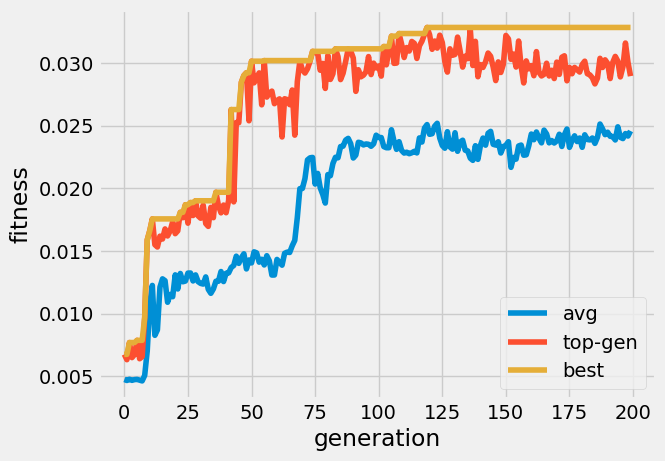

In [20]:
fitness = data['fitness']
avg_fitness = jnp.mean(fitness, axis=-1)
max_fitness = jnp.max(fitness, axis=-1)
best_fitness = -data['es_state'].best_fitness

plt.plot(avg_fitness, label='avg')
plt.plot(max_fitness, label='top-gen')
plt.plot(best_fitness, label='best')
plt.legend()
plt.xlabel('generation')
plt.ylabel('fitness')
plt.show()

In [21]:
best_params = es_state.best_member
best_params = parameter_reshaper.reshape(best_params[None, :])
best_params = jax.tree_map(lambda x: x[0], best_params)
test_key = jax.random.PRNGKey(90)
fit_best, best_test_data = evaluator.test(test_key, best_params, n_samples=1000, 
                                  render=False)
bd_extractor = evaluator.config.bd_extractor
bds_best = jax.vmap(bd_extractor)(best_test_data)
fit_best

Array(0.18746978, dtype=float32)

In [22]:
worst_params = data['es_state'].best_member[0]
worst_params = parameter_reshaper.reshape(worst_params[None, :])
worst_params = jax.tree_map(lambda x: x[0], worst_params)
test_key = jax.random.PRNGKey(66)
fit_worst, worst_test_data = evaluator.test(test_key, worst_params, n_samples=1000, 
                                  render=False)
bd_extractor = evaluator.config.bd_extractor
bds_worst = jax.vmap(bd_extractor)(worst_test_data)
fit_worst

Array(0.03901596, dtype=float32)

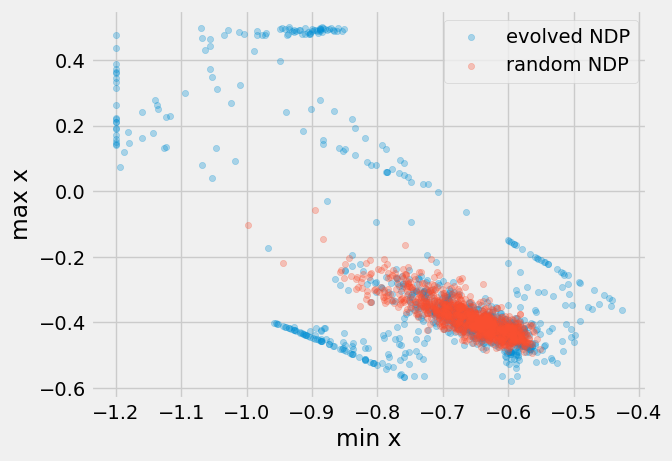

In [23]:
s=20.
plt.scatter(bds_best[:, 0], bds_best[:, 1], label='evolved NDP',
           alpha = .3, s=s)
plt.scatter(bds_worst[:, 0], bds_worst[:, 1], label='random NDP',
           alpha=.3, s=s)
plt.legend()
plt.xlabel('min x')
plt.ylabel('max x')
plt.show()

In [24]:
import pandas as pd
import seaborn as sns

In [25]:
data_best = pd.DataFrame()
data_best[["BC_1", "BC_2"]] = bds_best
data_best['NDP'] = "HyperNCA - evolved"

In [26]:
data_wrst = pd.DataFrame()
data_wrst[["BC_1", "BC_2"]] = bds_worst
data_wrst['NDP'] = "HyperNCA - random"

In [27]:
full_data = pd.concat([data_best, data_wrst])

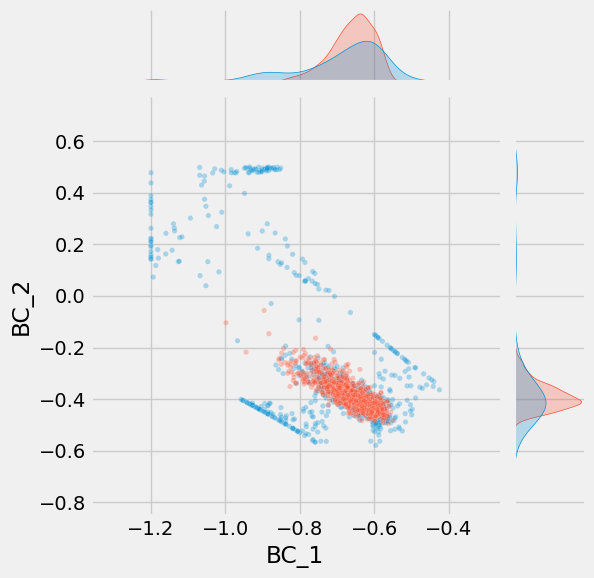

In [28]:
sns.jointplot(data=full_data, x="BC_1", y="BC_2", hue="NDP", kind='scatter',
             alpha = .3, s= 15., legend=False)

In [29]:
best_members = data['es_state'].best_member

### Evaluate compositionality

In [30]:
from evaluators import CompositionalityEvaluator, CompositionalityEvaluator_Config

In [31]:
evaluator_config = CompositionalityEvaluator_Config(
    epochs = 1,
    env = env,
    env_backend = "gymnax",
    env_params = env_params,
    env_steps = 200,
    n_params = z_dims,
    bd_extractor = bd_extractors[env_name],
    popsize = 60
)
evaluator = CompositionalityEvaluator(evaluator_config, ndp, policy)

In [32]:
key_eval = jax.random.PRNGKey(42)
keys_eval = jax.random.split(key_eval, best_members.shape[0])
ndp_params = parameter_reshaper.reshape(best_members)
compos, data_compo = jax.vmap(evaluator.eval)(ndp_params, keys_eval)

	INNER LOOP #0


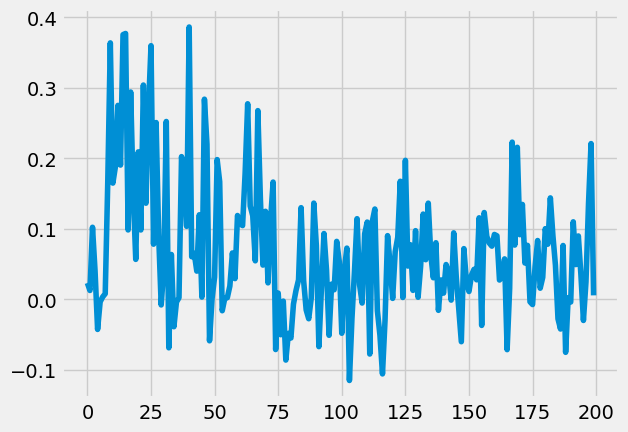

In [33]:
plt.plot(compos)

# Eval

In [34]:
# from evaluators.simple_evaluator import SimpleEvaluator, SimpleEvaluator_Config

In [35]:
# opt_config = SimpleEvaluator_Config(
#     epochs = 200,
#     env = env,
#     env_params = env_params,
#     env_steps = 200,
#     mlp_hidden_dims = mlp_hidden_dims,
#     mlp_hidden_layers = mlp_hidden_layers,
#     n_params = z_dims,
#     es = "openes",
#     popsize = 128
# )

# opt = SimpleEvaluator(opt_config, ndp)

In [36]:
# key = jax.random.PRNGKey(33)
# best_fit, best_data = opt.eval(best_params, key)
# best_fit

In [37]:
# fitness = best_data['fitness']
# avg_fitness = jnp.mean(fitness, axis=-1)
# max_fitness = jnp.max(fitness, axis=-1)
# best_fitness = -best_data['es_state'].best_fitness

# plt.plot(avg_fitness, label='avg')
# plt.plot(max_fitness, label='top-gen')
# plt.plot(best_fitness, label='best')
# plt.legend()
# plt.xlabel('generation')
# plt.ylabel('fitness')
# plt.show()

In [38]:
# worst_fit, worst_data = opt.eval(worst_params, key)

In [39]:
# fitness = worst_data['fitness']
# avg_fitness = jnp.mean(fitness, axis=-1)
# max_fitness = jnp.max(fitness, axis=-1)
# best_fitness = -best_data['es_state'].best_fitness

# plt.plot(avg_fitness, label='avg')
# plt.plot(max_fitness, label='top-gen')
# plt.plot(best_fitness, label='best')
# plt.legend()
# plt.xlabel('generation')
# plt.ylabel('fitness')
# plt.show()

# Visualize

In [40]:
# %%capture
# best_params = es_state.best_member
# best_params = parameter_reshaper.reshape(best_params[None, :])
# best_params = jax.tree_map(lambda x: x[0], best_params)
# test_key = jax.random.PRNGKey(66)
# fit, test_data, files = evaluator.test(test_key, best_params, n_samples=5, 
#                                   render=True, save_file="best")

In [41]:
# ipyplot.plot_images(files)

In [42]:
# %%capture
# worst_params = data['es_state'].best_member[0]
# worst_params = parameter_reshaper.reshape(worst_params[None, :])
# worst_params = jax.tree_map(lambda x: x[0], worst_params)
# test_key = jax.random.PRNGKey(66)
# fit, test_data, files = evaluator.test(test_key, worst_params, n_samples=5, 
#                                   render=True, save_file="best")

In [43]:
# ipyplot.plot_images(files)